In [252]:
# !pip install prophet

In [253]:
import itertools
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from prophet import Prophet
# from neuralprophet import NeuralProphet
from sklearn.metrics import mean_squared_error as mse
import math
import datetime
from calendar import monthrange
from prophet.diagnostics import cross_validation,performance_metrics
from sklearn.model_selection import TimeSeriesSplit

In [254]:
train = pd.read_csv('../input/forecast-green-energy/train_IxoE5JN.csv')
test = pd.read_csv('../input/forecast-green-energy/test_WudNWDM.csv')
sample = pd.read_csv('../input/forecast-green-energy/sample_submission_jn0a7vR.csv')

In [255]:
train

,row_id,datetime,energy
0,1,2008-03-01 00:00:00,1259.985563
1,2,2008-03-01 01:00:00,1095.541500
2,3,2008-03-01 02:00:00,1056.247500
3,4,2008-03-01 03:00:00,1034.742000
4,5,2008-03-01 04:00:00,1026.334500
...,...,...,...
94987,94988,2018-12-31 19:00:00,2528.446800
94988,94989,2018-12-31 20:00:00,2461.883600
94989,94990,2018-12-31 21:00:00,2365.994400
94990,94991,2018-12-31 22:00:00,2342.942800


In [256]:
train.dropna(axis = 0, inplace = True)
train.reset_index(drop = True, inplace = True)

In [257]:
def create_date_featues(df):

#     df['Year'] = pd.to_datetime(df['datetime']).dt.year
    df['Month'] = pd.to_datetime(df['datetime']).dt.month

    df['Month_cos'] = np.cos(2*math.pi* pd.to_datetime(df['datetime']).dt.month/12)
    df['Month_sin'] = np.sin(2*math.pi* pd.to_datetime(df['datetime']).dt.month/12)
    df['Month_bins'] = pd.cut(df['Month'], bins = 4, labels = False)
    df['Day_sin'] = np.sin(2 * math.pi * pd.to_datetime(df['datetime']).dt.day/31)
    df['Day_cos'] = np.cos(2 * math.pi * pd.to_datetime(df['datetime']).dt.day/31)

    df['Dayofweek_sin'] = np.sin(2 * math.pi * pd.to_datetime(df['datetime']).dt.dayofweek/6)
    df['Dayofweek_cos'] = np.cos(2 * math.pi * pd.to_datetime(df['datetime']).dt.dayofweek/6)

#     df['DayOfyear'] = pd.to_datetime(df['datetime']).dt.dayofyear

#     df['Week'] = pd.to_datetime(df['datetime']).dt.week

    df['Quarter'] = pd.to_datetime(df['datetime']).dt.quarter 

    df['Is_month_start'] = pd.to_datetime(df['datetime']).dt.is_month_start

    df['Is_month_end'] = pd.to_datetime(df['datetime']).dt.is_month_end

    df['Is_quarter_start'] = pd.to_datetime(df['datetime']).dt.is_quarter_start

    df['Is_quarter_end'] = pd.to_datetime(df['datetime']).dt.is_quarter_end

    df['Is_year_start'] = pd.to_datetime(df['datetime']).dt.is_year_start

    df['Is_year_end'] = pd.to_datetime(df['datetime']).dt.is_year_end

#     df['Semester'] = np.where(df['Quarter'].isin([1,2]),1,2)
    df['Dayofweek'] = pd.to_datetime(df['datetime']).dt.dayofweek

    df['Is_weekend'] = np.where(df['Dayofweek'].isin([5,6]),1,0)

    df['Is_weekday'] = np.where(df['Dayofweek'].isin([0,1,2,3,4]),1,0)
    df['Days_diff_from_today'] = (datetime.datetime.now() - pd.to_datetime(df['datetime'])).dt.days
#     df['Days_diff_from_today'] = (datetime.datetime.now() - df['datetime']).dt.days
#     df['Is_Monday'] = np.where(df['Dayofweek'] == 0, 1, 0)
#     df['Fritosat'] = np.where(df['Dayofweek'].isin([4,5]), 1, 0)
#     df['Tuetowed'] = np.where(df['Dayofweek'].isin([1,2]), 1, 0)
#     df['junetojul'] = np.where(df['Month'].isin([5,6]),1, 0)
#     df['Days_in_month'] = pd.to_datetime(df['datetime']).dt.days_in_month
    df['Hour'] = pd.to_datetime(df['datetime']).dt.hour
#     df['Hour_cos'] = np.cos(2* math.pi * ((pd.to_datetime(df['datetime']).dt.hour)/23))
#     df['Hour_sin'] = np.sin(2* math.pi * ((pd.to_datetime(df['datetime']).dt.hour)/23))
#     df['00to3'] = np.where(df['Hour'].isin([0,1,2,3]), 1, 0)
#     df['3to6'] = np.where(df['Hour'].isin([3,4,5,6]), 1, 0)
#     df['10to17'] = np.where(df['Hour'].isin([10,11,12,13,14,15,16,17]), 1, 0)
#     df['17to20'] = np.where(df['Hour'].isin([17, 18, 19, 20]), 1, 0)
    df.drop(['Month','Dayofweek'], axis = 1, inplace = True)

    return df

In [258]:
train=create_date_featues(train)
test=create_date_featues(test)

In [259]:
train['is_train'] = 1
test['is_train'] = 0
df = pd.concat([train, test], axis = 0)
df['lag_3'] = df['energy'].shift(3*24*31*12)
df['lag_4'] = df['energy'].shift(4*24*31*12)
df['lag_5'] = df['energy'].shift(5*24*31*12)
df['lag_6'] = df['energy'].shift(6*24*31*12)
df['lag_7'] = df['energy'].shift(7*24*31*12)
# df['lag_8'] = df['energy'].shift(8*24*31*12)

train = df[df['is_train'] == 1]
test = df[df['is_train'] == 0]
train.drop(['is_train', 'row_id'], axis = 1, inplace=True)
test.drop(['is_train', 'row_id'], axis = 1, inplace = True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [260]:
cols = train.columns.tolist()
cols

['datetime',
 'energy',
 'Month_cos',
 'Month_sin',
 'Month_bins',
 'Day_sin',
 'Day_cos',
 'Dayofweek_sin',
 'Dayofweek_cos',
 'Quarter',
 'Is_month_start',
 'Is_month_end',
 'Is_quarter_start',
 'Is_quarter_end',
 'Is_year_start',
 'Is_year_end',
 'Is_weekend',
 'Is_weekday',
 'Days_diff_from_today',
 'Hour',
 'lag_3',
 'lag_4',
 'lag_5',
 'lag_6',
 'lag_7']

In [261]:
col = cols[3:]
col

['Month_sin',
 'Month_bins',
 'Day_sin',
 'Day_cos',
 'Dayofweek_sin',
 'Dayofweek_cos',
 'Quarter',
 'Is_month_start',
 'Is_month_end',
 'Is_quarter_start',
 'Is_quarter_end',
 'Is_year_start',
 'Is_year_end',
 'Is_weekend',
 'Is_weekday',
 'Days_diff_from_today',
 'Hour',
 'lag_3',
 'lag_4',
 'lag_5',
 'lag_6',
 'lag_7']

In [262]:
train = train.rename(columns = {'energy': 'y', 'datetime': 'ds'})
test = test.rename(columns = {'datetime': 'ds'})
train['y_orig'] = train['y']
train['y'] = np.log(train['y'])

In [263]:
# train.loc[(train['ds'] > '2014-12-31') & (train['ds'] <= '2018-12-31'), 'y'] = None
# train['cap'] = 8

In [264]:
train.shape

(93092, 26)

In [265]:
train = train.dropna()

In [266]:
model = Prophet()
# model = Prophet()
for i in col:
    print(str(i))
    model.add_regressor(str(i))

Month_sin
Month_bins
Day_sin
Day_cos
Dayofweek_sin
Dayofweek_cos
Quarter
Is_month_start
Is_month_end
Is_quarter_start
Is_quarter_end
Is_year_start
Is_year_end
Is_weekend
Is_weekday
Days_diff_from_today
Hour
lag_3
lag_4
lag_5
lag_6
lag_7


In [267]:
model.fit(train)

13:09:44 - cmdstanpy - INFO - Chain [1] start processing
13:10:32 - cmdstanpy - INFO - Chain [1] done processing


In [268]:
future_data = model.make_future_dataframe(periods = len(test), freq = 'H')
train_data = model.predict(train)
forecast_data = model.predict(test)
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)

,ds,yhat,yhat_lower,yhat_upper
26299,2021-12-31 19:00:00,7.954181,1.988881,13.788193
26300,2021-12-31 20:00:00,7.958583,1.997947,13.874272
26301,2021-12-31 21:00:00,7.950916,2.021991,13.788098
26302,2021-12-31 22:00:00,7.925975,2.011542,13.777044
26303,2021-12-31 23:00:00,7.886708,1.905900,13.750514


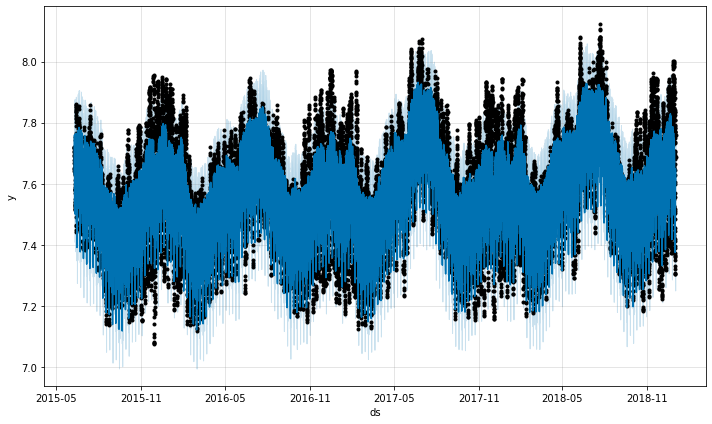

In [269]:
fig = model.plot(train_data)

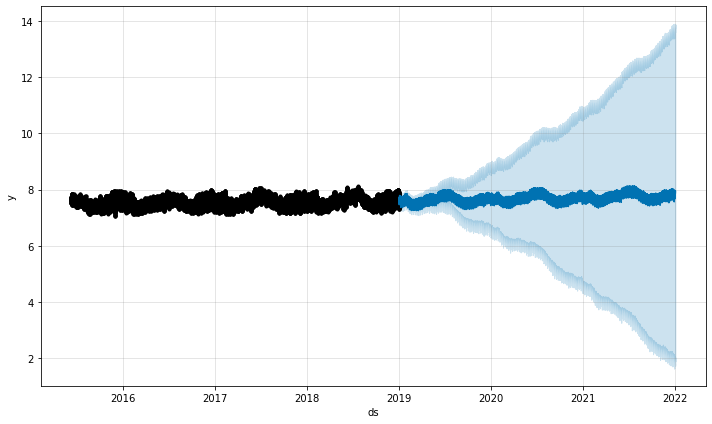

In [270]:
fig = model.plot(forecast_data)

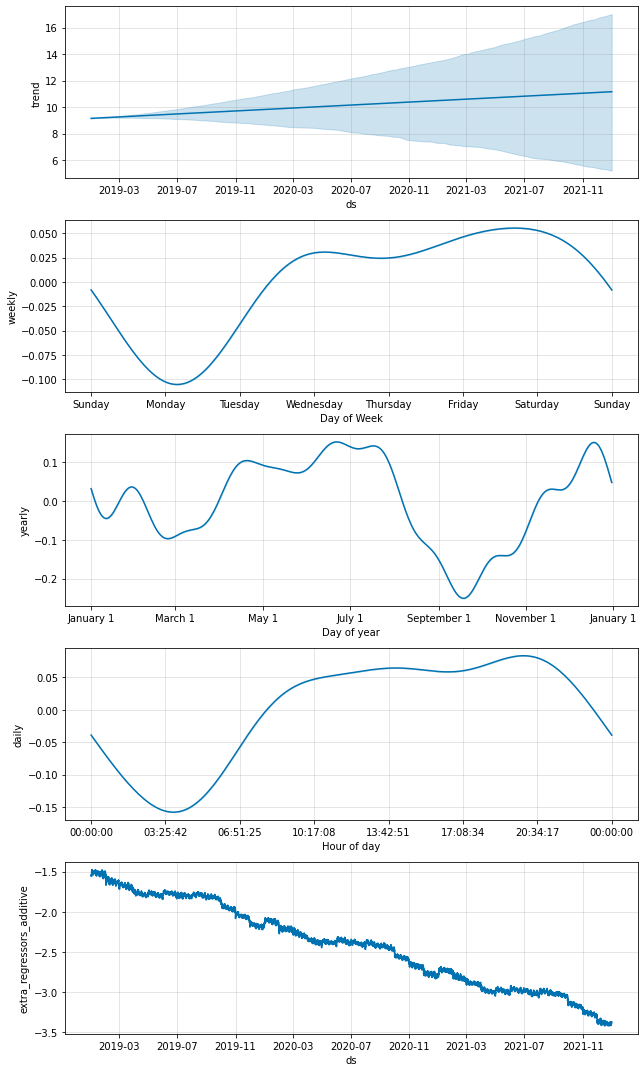

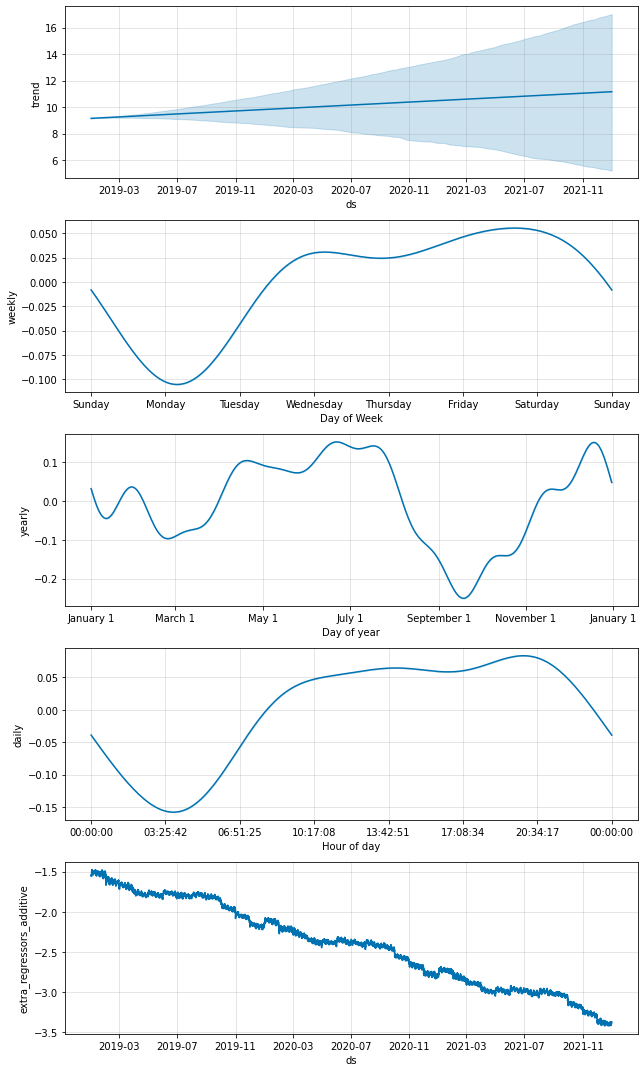

In [271]:
model.plot_components(forecast_data)

In [272]:
forecast_data_orig = forecast_data
forecast_data_orig['yhat'] = np.exp(forecast_data_orig['yhat'])
forecast_data_orig['yhat_lower'] = np.exp(forecast_data_orig['yhat_lower'])
forecast_data_orig['yhat_upper'] = np.exp(forecast_data_orig['yhat_upper'])

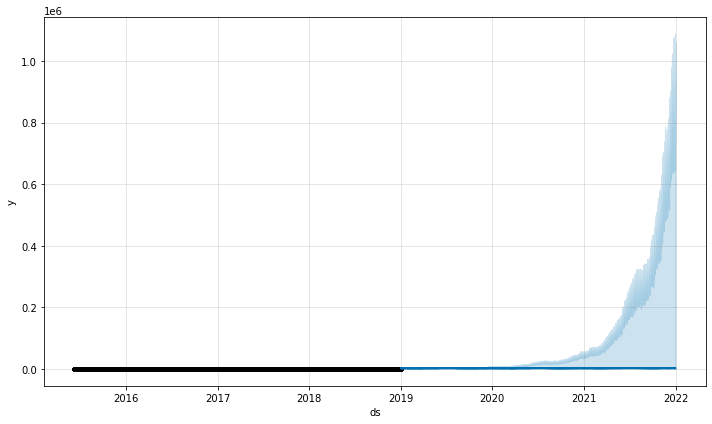

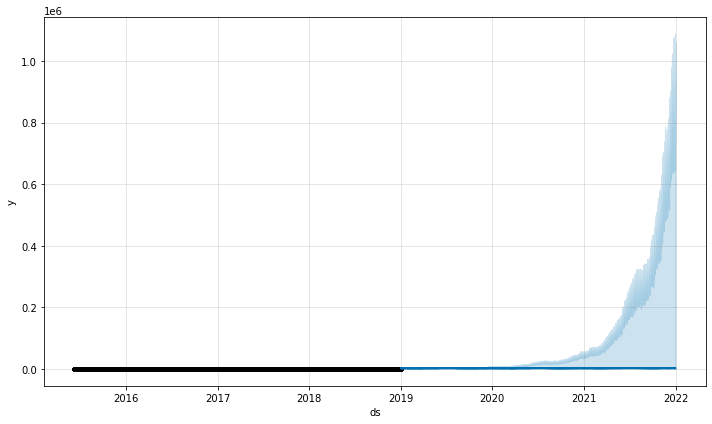

In [273]:
model.plot(forecast_data_orig)

In [274]:
train['y_log'] = train['y']
train['y'] = train['y_orig']

In [275]:
final_df = pd.DataFrame(forecast_data_orig)
import plotly.graph_objs as go
import plotly.offline as py

actual_chart = go.Scatter(y=train['y_orig'], name = 'Actual')
predict_chart = go.Scatter(y = final_df['yhat'], name = 'Predicted')
predict_chart_upper = go.Scatter(y = final_df['yhat_upper'], name = 'Predicted Upper')
predict_chart_lower = go.Scatter(y = final_df['yhat_lower'], name = 'Predicted Lower')
py.plot([actual_chart, predict_chart, predict_chart_upper, predict_chart_lower])

'temp-plot.html'

In [276]:
# param_grid = {  
#     'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
#     'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
# }

# # Generate all combinations of parameters
# all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
# rmses = []  # Store the RMSEs for each params here

# # Use cross validation to evaluate all parameters
# for params in all_params:
#     m = Prophet(**params).fit(df)  # Fit model with given params
#     df_cv = cross_validation(m, cutoffs=cutoffs, horizon='30 days', parallel="processes")
#     df_p = performance_metrics(df_cv, rolling_window=1)
#     rmses.append(df_p['rmse'].values[0])

# # Find the best parameters
# tuning_results = pd.DataFrame(all_params)
# tuning_results['rmse'] = rmses
# print(tuning_results)

In [277]:
# cv_results = cross_validation(model = model, horizon = '730 days')

In [278]:
# df_p = performance_metrics(cv_results)
# df_p

In [279]:
# df_p['rmse'].describe()

In [280]:
final_df

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Day_cos,Day_cos_lower,Day_cos_upper,Day_sin,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-01-01 00:00:00,9.154440,1690.678082,2.169124e+03,9.154440,9.154440,0.000826,0.000826,0.000826,-0.000290,...,-0.043161,-0.043161,-0.043161,0.038658,0.038658,0.038658,0.0,0.0,0.0,1913.242859
1,2019-01-01 01:00:00,9.154516,1626.317292,2.055653e+03,9.154516,9.154516,0.000826,0.000826,0.000826,-0.000290,...,-0.038360,-0.038360,-0.038360,0.038124,0.038124,0.038124,0.0,0.0,0.0,1842.219907
2,2019-01-01 02:00:00,9.154592,1587.370488,2.002728e+03,9.154592,9.154592,0.000826,0.000826,0.000826,-0.000290,...,-0.033582,-0.033582,-0.033582,0.037591,0.037591,0.037591,0.0,0.0,0.0,1782.181713
3,2019-01-01 03:00:00,9.154669,1554.580919,1.971986e+03,9.154669,9.154669,0.000826,0.000826,0.000826,-0.000290,...,-0.028853,-0.028853,-0.028853,0.037058,0.037058,0.037058,0.0,0.0,0.0,1746.379499
4,2019-01-01 04:00:00,9.154745,1557.060312,1.958346e+03,9.154745,9.154745,0.000826,0.000826,0.000826,-0.000290,...,-0.024199,-0.024199,-0.024199,0.036525,0.036525,0.036525,0.0,0.0,0.0,1746.934125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26299,2021-12-31 19:00:00,11.163071,7.307354,9.730526e+05,5.211405,17.010173,0.000843,0.000843,0.000843,-0.000005,...,0.055213,0.055213,0.055213,0.038124,0.038124,0.038124,0.0,0.0,0.0,2847.456250
26300,2021-12-31 20:00:00,11.163147,7.373904,1.060522e+06,5.211031,17.010582,0.000843,0.000843,0.000843,-0.000005,...,0.054971,0.054971,0.054971,0.037591,0.037591,0.037591,0.0,0.0,0.0,2860.018189
26301,2021-12-31 21:00:00,11.163223,7.553346,9.729602e+05,5.210656,17.010991,0.000843,0.000843,0.000843,-0.000005,...,0.054636,0.054636,0.054636,0.037058,0.037058,0.037058,0.0,0.0,0.0,2838.173373
26302,2021-12-31 22:00:00,11.163300,7.474838,9.622643e+05,5.210281,17.011400,0.000843,0.000843,0.000843,-0.000005,...,0.054202,0.054202,0.054202,0.036525,0.036525,0.036525,0.0,0.0,0.0,2768.261716


In [281]:
rows = final_df['yhat']
sample['energy'] = rows
sample.to_csv('fbprophet_tfe_shift_34567.csv', index = False)

In [282]:
sample

,row_id,energy
0,94993,1913.242859
1,94994,1842.219907
2,94995,1782.181713
3,94996,1746.379499
4,94997,1746.934125
...,...,...
26299,121292,2847.456250
26300,121293,2860.018189
26301,121294,2838.173373
26302,121295,2768.261716
